In [1]:
import os
import base64
import folium
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
# CONSTANTS
MATERIALS = ['Hazardous Material', 'Other', 'Oxygenates', 'Petroleum', 'raw sewage']

MIN_CIRCLE_SIZE = 7
MAX_CIRCLE_SIZE = 70
TOP_THRESHOLD = 3
LEGEND_HTML = '''
<div style="position: fixed; bottom: 30px; left: 30px; width: 170px; height: 130px; 
background-color: white; border:2px solid grey; z-index:9999; font-size:14px;">
    &nbsp; Other &nbsp; <i class="fa fa-circle fa-1x" style="color:#4682B4"></i><br>
    &nbsp; Petroleum &nbsp; <i class="fa fa-circle fa-1x" style="color:#8B4513"></i><br>
    &nbsp; Hazardous Material &nbsp; <i class="fa fa-circle fa-1x" style="color:#D02090"></i><br>
    &nbsp; Oxygenates &nbsp; <i class="fa fa-circle fa-1x" style="color:#40E0D0"></i>
</div>'''
LARGEST_MATERIAL = 'raw sewage'

QUANTITY_LABELS = ['Major\n(>1000L)', 'Large', 'Minor\n(<30L)']
COLORS = {
    'raw sewage': '#556B2F',           # Dark Olive Green
    'Other': '#4682B4',               # Steel Blue
    'Petroleum': '#8B4513',           # Saddle Brown
    'Hazardous Material': '#D02090',  # Violet Red
    'Oxygenates': '#40E0D0'          # Turquoise
}

# Style
# Adjusted Style
box_style = {'boxstyle': 'round', 'facecolor': 'lightgrey', 'alpha': 0.7, 'edgecolor': 'none'}
text_style = {'verticalalignment': 'top', 'color': 'black', 'bbox': box_style}
legend_style = {'fontsize': 11, 'edgecolor': 'none', 'facecolor': 'lightgrey'}
style_title = {'fontsize': 17, 'fontweight': 'normal'}

In [3]:
# Helper functions
def calc_plotline(colunms):
    z = np.polyfit(colunms.index, colunms.values, 1)
    p = np.poly1d(z)
    return p

def assign_group(quantity):
    # Define the thresholds for each group
    major_threshold = 1000  # Example threshold for 'Major' spills
    large_threshold = 31   # Example threshold for 'Large' spills
    # Assume anything below the 'large_threshold' is 'Minor'

    if quantity >= major_threshold:
        return QUANTITY_LABELS[0]
    elif quantity >= large_threshold:
        return QUANTITY_LABELS[1]
    else:
        return QUANTITY_LABELS[2]
    
# Create and save a piechart
def create_pie_chart(county, data, file_path):
    fig = go.Figure(data=[go.Pie(
        labels=list(data.keys()),
        values=list(data.values()),
        hole=0.4,
        marker_colors=[COLORS.get(material, "#333333") for material in data.keys()],
        textinfo='none'
    )])

    fig.update_layout(
        showlegend=False,
        margin=dict(t=0, b=0, l=0, r=0),
        paper_bgcolor='rgba(0,0,0,0)',
        annotations=[dict(
            text=county,
            x=0.5, y=0.5,
            font_size=50,
            showarrow=False
        )]
    )

    fig.write_image(file_path, format="svg", width=350, height=350)

def add_circle_and_marker(map_object, center_coords, radius, color, text):

    # Add a circle to the map
    folium.Circle(
        location=center_coords,
        radius=radius,
        color=color,
        fill=True,
        fill_opacity=0.2,
        fill_color=color,
    ).add_to(map_object)

    # Clean text to remove line breaks and display it in one line
    cleaned_text = text.replace('\n', ' ')

    # Add a marker with text to the map
    folium.Marker(
        location=center_coords,
        icon=folium.DivIcon(html=f'<div style="font-size: 12pt; color: black; white-space: nowrap;">{cleaned_text}</div>')
    ).add_to(map_object)



def add_background_color(fig, domain, color):
    fig.add_shape(
        type="rect",
        xref="paper", yref="paper",
        x0=domain[0], y0=0, x1=domain[1], y1=1,
        fillcolor=color,
        layer="below",
        line_width=0,
    )

In [4]:
# Viz.1: DATA PREP & CONSTANTS
spills = pd.read_csv('Spill_Incidents_cleaned_since_1990_with_centroids.csv')

# Add year column
spills['Spill Date'] = pd.to_datetime(spills['Spill Date'])
spills['Spill Year'] = spills['Spill Date'].dt.year

# Group data by 'Spill Year' and 'Material Family'
spill_count_by_year_family = spills.groupby(['Spill Year', 'Material Family']).size().unstack(fill_value=0)

# Variables for viz
colors = [COLORS.get(x, "#333333") for x in spill_count_by_year_family.columns]
common_material = spills["Material Family"].mode()[0]
median_quantity = spills[spills["Material Family"] == common_material]["Quantity"].median()

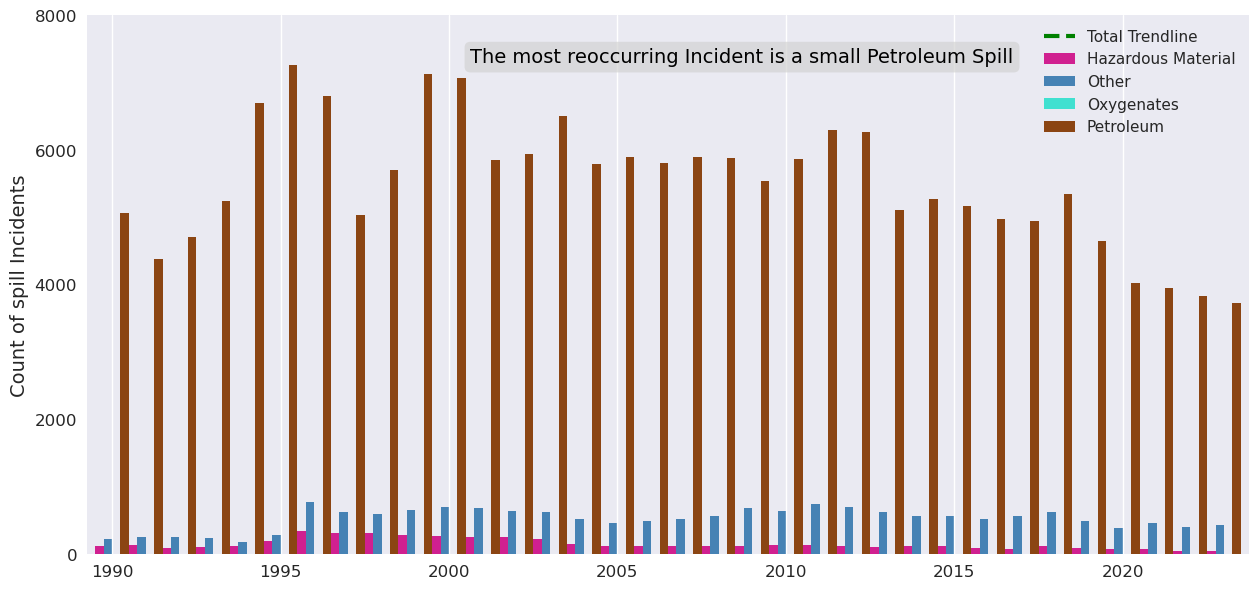

In [5]:
# Viz.1: Boxplot of Spill Quantity by Material Family TODO: Trendline

with plt.style.context("seaborn-v0_8"):
    fig, ax = plt.subplots(figsize=(15, 7))
    spill_count_by_year_family.plot(kind='bar', ax=ax, width=1.0, color=COLORS, zorder=0)

    # Setting title, labels, and custom fonts
    ax.set_xlabel('')

    # Calculating and plotting the trendline for total spills
    total_spills = spill_count_by_year_family.sum(axis=1)
    p = calc_plotline(total_spills)
    ax.plot(total_spills.index, p(total_spills.index), '--', label='Total Trendline', linewidth=3, color='green', zorder=10)

    # Adjust x-ticks and labels
    xticks = np.arange(len(total_spills.index))  # Assuming spill year is continuous and in order
    ax.set_xticks(xticks[::5])  # Show every 5th year
    ax.set_xticklabels(total_spills.index[::5], rotation=0)
    ax.set_ylabel('Count of spill Incidents', fontsize=14)
    ax.set_yticks(ax.get_yticks()[::2])
    ax.tick_params(labelsize=12)

    # Remove horizontal background lines
    ax.yaxis.grid(False)  # Turn off y-axis grid lines

    # Displaying custom box for most common spill information
    textstr = f'The most reoccurring Incident is a small {common_material} Spill'
    ax.text(0.33, 0.94, textstr, transform=ax.transAxes, **text_style, fontsize=14)


    # Adjusting legend to match the style of the box
    ax.legend(bbox_to_anchor=(1, 1), loc='upper right', **legend_style)

plt.savefig('viz1.png', bbox_inches='tight')
plt.show()

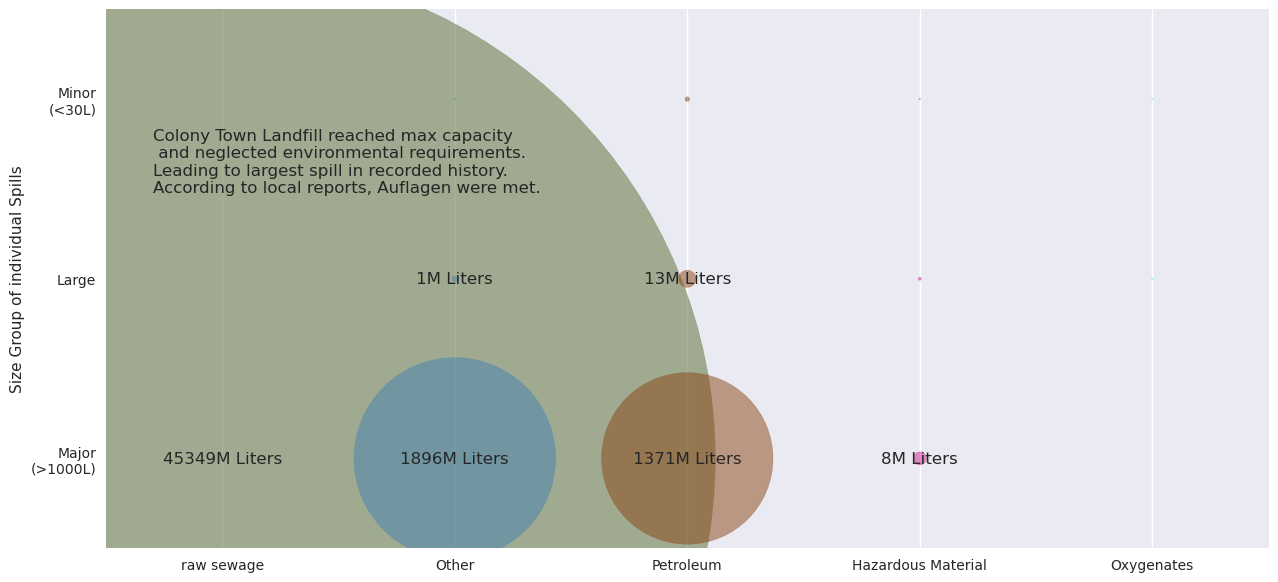

In [6]:
# Viz.2: Bubble Chart of Total Spill Quantity by Size and Material Family (modified)


# Load data
spills = pd.read_csv('Spill_Incidents_cleaned_since_1990_with_centroids.csv')

# Assuming assign_group is a function that assigns the 'Size Group' based on 'Quantity'
spills['Size Group'] = spills['Quantity'].apply(assign_group)
spills.loc[spills['Quantity'] == spills['Quantity'].max(), 'Material Family'] = 'raw sewage'

# Grouping and sorting
grouped_data = (spills.groupby(['Size Group', 'Material Family'])
                .agg({'Quantity': 'sum'})
                .reset_index()
                .sort_values(by=['Size Group', 'Quantity'], ascending=[True, False]))

grouped_data['Size Group'] = pd.Categorical(grouped_data['Size Group'], categories=QUANTITY_LABELS, ordered=True)
grouped_data.sort_values(by='Size Group', inplace=True)

# Reorder material mapping based on the new order of materials
ordered_materials = ['raw sewage', 'Other', 'Petroleum', 'Hazardous Material', 'Oxygenates']
material_mapping = {material: i for i, material in enumerate(ordered_materials)}
grouped_data['Material Family Num'] = grouped_data['Material Family'].map(material_mapping)

# Plotting
with plt.style.context("seaborn-v0_8"):
    fig, ax = plt.subplots(figsize=(15, 7))

    # Plotting bubbles for each material family
    for material in ordered_materials:
        subset = grouped_data[grouped_data['Material Family'] == material]
        bubble_sizes = subset['Quantity'].clip(lower=90000) / 90000
        ax.scatter(subset['Material Family Num'], subset['Size Group'], s=bubble_sizes, alpha=0.5, label=material, color=COLORS[material])

    # Adding total quantity text labels only for spills above 5 million liters
    for index, row in grouped_data.iterrows():
        if row['Quantity'] > 1e6:
            ax.text(row['Material Family Num'], row['Size Group'], f"{int(row['Quantity']/1e6)}M Liters", ha='center', va='center', fontsize=12)

    # Adjusting axes
    ax.set_ylabel('Size Group of individual Spills')
    ax.set_ylim(-0.5, len(QUANTITY_LABELS) - 0.5)
    ax.set_yticks(range(len(QUANTITY_LABELS)))
    ax.set_yticklabels(QUANTITY_LABELS)  # No need to reverse if already in correct order
    ax.yaxis.grid(False)  # Turn off y-axis grid lines
    ax.xaxis.grid(True)  # Optionally turn on x-axis grid lines
    ax.set_xticks(list(material_mapping.values()))
    ax.set_xticklabels(ordered_materials)

    # set start and end of x-axis
    ax.set_xlim(-0.5, len(material_mapping) - 0.5)

    # Custom legend

    # Custom text box for additional information
    textstr = 'Colony Town Landfill reached max capacity\n and neglected environmental requirements. \nLeading to largest spill in recorded history. \nAccording to local reports, Auflagen were met.'
    ax.text(0.04, 0.66, textstr, transform=ax.transAxes, fontsize=12)

plt.savefig('viz2.png', bbox_inches='tight')
plt.show()

In [7]:
# Viz.3-4: DATA PREP

# Load and clean data
raw_detailed_spills = pd.read_csv('Spill_Incidents_cleaned_since_1990_with_centroids.csv')
detailed_spills = raw_detailed_spills[raw_detailed_spills['Quantity'] < 10000000]

# Step 1: Calculate the total quantity for each county
county_totals = detailed_spills.groupby('County')['Quantity'].sum()

# Step 2: Assign a material group based on the quantity threshold
threshold = 0.05 * county_totals
#detailed_spills['Material Group'] = detailed_spills.apply(lambda x: 'Rest' if x['Quantity'] < threshold[x['County']] else x['Material Name'], axis=1)

# Step 3: Group by required columns
spills_by_county_material_group = detailed_spills.groupby(
    ['County', 'Material Family', 'Material Name']
).agg({
    'Quantity': 'sum',
    'CountyCentroidX': 'first',
    'CountyCentroidY': 'first',
}).reset_index()

# Group the data by county to process each county once
county_grouped = spills_by_county_material_group.groupby('County').agg({
    'CountyCentroidX': 'first',
    'CountyCentroidY': 'first',
    'Quantity': 'sum',
    'Material Family': lambda x: x.value_counts().idxmax()  # Most common material in the county
})
max_total_quantity = county_grouped['Quantity'].max()

# Determine top counties based on total and hazardous material spills
top_total_spills_counties = county_totals.nlargest(TOP_THRESHOLD).index
top_hazardous_spills_counties = detailed_spills[detailed_spills['Material Family'] == 'Hazardous Material'].groupby('County')['Quantity'].sum().nlargest(TOP_THRESHOLD).index

# Combine lists of top counties and remove duplicates
top_counties = set(top_total_spills_counties) | set(top_hazardous_spills_counties)
print(top_counties)

# Filter the original DataFrame for only the top counties
data_top_total = detailed_spills[detailed_spills['County'].isin(top_total_spills_counties)]
data_top_hazardous = detailed_spills[detailed_spills['County'].isin(top_hazardous_spills_counties)]
data_top = detailed_spills[detailed_spills['County'].isin(top_counties)]


{'Monroe', 'Nassau', 'Erie', 'Queens', 'Dutchess', 'Onondaga'}


In [8]:
# Viz.3: DATA PREP Create and save pie charts for top counties

# Create pie charts directory
os.makedirs('pie_charts', exist_ok=True)

# Aggregate data for pie charts
data_for_pie = data_top[data_top['County'].isin(top_counties)].groupby(['County', 'Material Family'])['Quantity'].sum()

# Generate and save pie charts for each county
for county in top_counties:
    material_quantities = data_for_pie[county].to_dict()
    file_path = f'pie_charts/{county}.svg'
    create_pie_chart(county, material_quantities, file_path)


In [9]:

MIN_ICON_SIZE = 40  # Minimum size of the icon
MAX_ICON_SIZE = 80  # Maximum size of the icon
# You can call the function as many times as needed for different circles and markers
CENTER_INDUSTRIAL = (42.770203, -77.309579)  # Replace with other coordinates
CENTER_DENSE = (40.997520, -73.884682)  # Replace with other coordinates


attribution = "Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL."
m = folium.Map(location=[41.993396, -75.596548], zoom_start=7, tiles="CartoDB Positron", attr=attribution, min_zoom=7)

add_circle_and_marker(m, CENTER_INDUSTRIAL, radius=150000, color='grey', text='Industrial Zone')
add_circle_and_marker(m, CENTER_DENSE, radius=120000, color='green', text='Densly-Populated Residential Zone')


for county, row in county_grouped.iterrows():
    # Scale the icon size based on the total spill quantity
    circle_size = max(MIN_CIRCLE_SIZE, row['Quantity'] / max_total_quantity * MAX_CIRCLE_SIZE)
    icon_size = min(max(circle_size * 1.5, MIN_ICON_SIZE * 2), MAX_ICON_SIZE * 1.5)

    if county in top_counties:
        # Pie chart marker for top counties
        svg_path = f'pie_charts/{county}.svg'
        with open(svg_path, 'r') as file:
            svg_content = file.read()
        svg_base64 = base64.b64encode(svg_content.encode('utf-8')).decode('utf-8')
        icon_html = f'<img src="data:image/svg+xml;base64,{svg_base64}" style="width: {icon_size}px; height: {icon_size}px;">'
        folium.Marker([row['CountyCentroidY'], row['CountyCentroidX']], icon=folium.DivIcon(html=icon_html)).add_to(m)
    else:
        # Circle marker for other counties
        color = COLORS.get(row['Material Family'], 'gray')

        folium.CircleMarker(
            location=[row['CountyCentroidY'], row['CountyCentroidX']],
            radius=circle_size,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.6,
            popup=f"{county}<br>Total Spills: {row['Quantity']}"
        ).add_to(m)

# Add legend and display the map
m.get_root().html.add_child(folium.Element(LEGEND_HTML))

m.save('viz3.html')

In [10]:
def create_sunburst(data, title, colors):
    return px.sunburst(
        data,
        path=['Material Family', 'Contributing Factor'],
        values='Quantity',
        color='Material Family',
        color_discrete_map=colors,
        title=title
    )
    
# Aggregate the data
hazardous_aggregated = data_top_hazardous.groupby(['Material Family', 'Contributing Factor'], as_index=False)['Quantity'].sum()
total_aggregated = data_top_total.groupby(['Material Family', 'Contributing Factor'], as_index=False)['Quantity'].sum()

# Create sunburst charts
fig_hazardous = create_sunburst(hazardous_aggregated, f"Reason for spills\nin industrial zones", COLORS)
fig_total = create_sunburst(total_aggregated, f"Reason for spills\nin residential/urban zones", COLORS)

# Create a subplot with 2 columns
fig = make_subplots(rows=1, cols=2, subplot_titles=[fig_hazardous.layout.title.text, fig_total.layout.title.text], specs=[[{'type': 'domain'}, {'type': 'domain'}]])
domain_col1 = [0, 0.5]
domain_col2 = [0.5, 1]



# Add traces from the individual sunburst charts to the subplot
for trace in fig_hazardous.data:
    fig.add_trace(trace, row=1, col=1)
    add_background_color(fig, domain_col1, '#d5d5d3')
for trace in fig_total.data:
    fig.add_trace(trace, row=1, col=2)
    add_background_color(fig, domain_col2, '#b9d5b4')




# Show the combined figure
fig.show()
fig.write_image('viz4.png', width=1000, height=500)